In [1]:
import openmc
import numpy as np
import os
import math
import matplotlib.pyplot as plt
import pandas as pd
import kdsource as kds
from mpl_toolkits.mplot3d import Axes3D as ax

In [2]:
openmc_data = "/home/agusgimenez/Desktop/Secciones/endfb-viii.0-hdf5/cross_sections.xml"
os.environ["OPENMC_CROSS_SECTIONS"] = openmc_data
openmc.config['cross_sections'] = openmc_data

In [3]:
mat01 = openmc.Material(material_id=0) #agua
mat01.add_nuclide('H1',2.000,'ao')
mat01.add_nuclide('O16',0.9976,'ao')
mat01.add_nuclide('O17',0.00035,'ao')
mat01.add_s_alpha_beta('c_H_in_H2O')
mat01.set_density('g/cm3',1.00)

In [4]:
W_vacio = 2.5
W_total = 22.5
L       = 300
z_Source= 30

<Axes: xlabel='x [cm]', ylabel='z [cm]'>

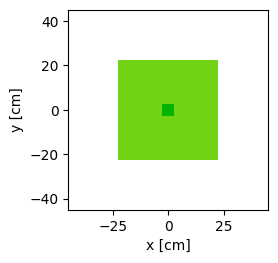

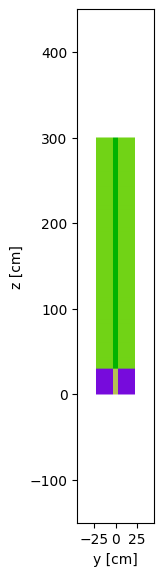

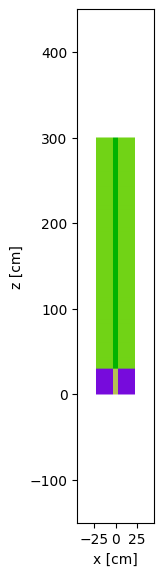

In [5]:
#bloque mat01
surf1_v = openmc.XPlane(-W_vacio)
surf1_v.boundary_type = 'transmission'

surf6_v = openmc.XPlane(W_vacio)
surf6_v.boundary_type = 'transmission'



surf2_v = openmc.YPlane(-W_vacio)
surf2_v.boundary_type = 'transmission'


surf5_v = openmc.YPlane(W_vacio)
surf5_v.boundary_type = 'transmission'

surf1_a = openmc.XPlane(-W_total)
surf1_a.boundary_type = 'vacuum'

surf6_a = openmc.XPlane(W_total)
surf6_a.boundary_type = 'vacuum'

surf2_a = openmc.YPlane(-W_total)
surf2_a.boundary_type = 'vacuum'

surf5_a = openmc.YPlane(W_total)
surf5_a.boundary_type = 'vacuum'



surf3 = openmc.ZPlane(0)
surf3.boundary_type = 'vacuum'

surf_source = openmc.ZPlane(z_Source)
surf_source.boundary_type = "transmission"

surf4 = openmc.ZPlane(L)
surf4.boundary_type = 'vacuum'



cell01_v = openmc.Cell(fill=None,cell_id=1)
cell01_v.region = +surf1_v & -surf6_v & +surf2_v & -surf5_v & +surf3 & -surf_source

cell01_a = openmc.Cell(fill=mat01,cell_id=2)
cell01_a.region = +surf1_a & -surf6_a & +surf2_a & -surf5_a & +surf3 & -surf_source & ~cell01_v.region


cell02_v = openmc.Cell(fill=None,cell_id=3)
cell02_v.region = +surf1_v & -surf6_v & +surf2_v & -surf5_v & +surf_source & -surf4

cell02_a = openmc.Cell(fill=mat01,cell_id=4)
cell02_a.region = +surf1_a & -surf6_a & +surf2_a & -surf5_a & +surf_source & -surf4 & ~cell01_v.region



univ01 = openmc.Universe(cells=[cell01_v,cell01_a,cell02_a,cell02_v],universe_id=1) 
univ01.plot(origin=(0.0,0.0,L/2),width=(4*W_total,4*W_total))
univ01.plot(origin=(0.0,0.0,L/2),width=(4*W_total,2*L),basis='yz')
univ01.plot(origin=(0.0,0.0,L/2),width=(4*W_total,2*L),basis='xz')


In [6]:
S = openmc.Source()
S.particle = 'neutron'
#dist_espacial'

x = openmc.stats.Uniform(W_total,-W_total)
y = openmc.stats.Uniform(W_total,-W_total)
z = openmc.stats.Discrete(0.1,1)
S.space = openmc.stats.CartesianIndependent(x,y,z)

#dist_Energia
S.energy = openmc.stats.Discrete(3E6,1.0)

#dist_angular.

S.angle = openmc.stats.Isotropic()

/home/agusgimenez/anaconda3/envs/openmc_develop/lib/python3.9/site-packages/openmc/source.py:539: FutureWarning: This class is deprecated in favor of 'IndependentSource'
  warnings.warn("This class is deprecated in favor of 'IndependentSource'", FutureWarning)


In [7]:
tallies = openmc.Tallies()


#FILTRO PARTICULA
Filtro_particula_neutron    =   openmc.ParticleFilter(['neutron'],filter_id = 0)

#GRILLA

mesh_vacio_xy = openmc.RegularMesh.from_domain(domain=univ01,dimension=(100,100,1),mesh_id=1)
mesh_vacio_xy.lower_left = [-W_total, -W_total, 0]
mesh_vacio_xy.upper_rigth = [W_total, W_total, L]

mesh_vacio_xz = openmc.RegularMesh.from_domain(domain=univ01,dimension=(100,1,500),mesh_id=2)
mesh_vacio_xz.lower_left = [-W_total, -W_total, 0]
mesh_vacio_xz.upper_rigth = [W_total, W_total, L]

mesh_vacio_yz = openmc.RegularMesh.from_domain(domain=univ01,dimension=(1,100,500),mesh_id=3)
mesh_vacio_yz.lower_left = [-W_total, -W_total, 0]
mesh_vacio_yz.upper_rigth = [W_total, W_total, L]

#FILTRO ESPACIAL

filt_vacio_xy = openmc.filter.MeshFilter(mesh_vacio_xy,filter_id=1)
filt_vacio_xz = openmc.filter.MeshFilter(mesh_vacio_xz,filter_id=2)
filt_vacio_yz = openmc.filter.MeshFilter(mesh_vacio_yz,filter_id=3)


#Tallys

dist_vacio_xy = openmc.Tally(name='vacio_xy' , tally_id=1)
dist_vacio_xy.scores = ["flux"]
dist_vacio_xy.filters = [filt_vacio_xy, Filtro_particula_neutron]
tallies.append(dist_vacio_xy)

dist_vacio_xz = openmc.Tally(name='vacio_xz' , tally_id=2)
dist_vacio_xz.scores = ["flux"]
dist_vacio_xz.filters = [filt_vacio_xz, Filtro_particula_neutron]
tallies.append(dist_vacio_xz)

dist_vacio_yz = openmc.Tally(name='vacio_yz' , tally_id=3)
dist_vacio_yz.scores = ["flux"]
dist_vacio_yz.filters = [filt_vacio_yz, Filtro_particula_neutron]
tallies.append(dist_vacio_yz)


In [8]:
#Numero de particulas 
N = int(1E6)

param = openmc.Settings()
param.source = S
param.run_mode = "fixed source"
param.batches = 1
param.particles = N

# Superficies donde escribe las particulas
superficies = [surf_source.id]

param.surf_source_write = {
    'surface_ids': superficies,
    'max_particles': len(superficies)*N,
    'mcpl':True
}

In [9]:
geom = openmc.Geometry(univ01)
geom.export_to_xml()

mats = openmc.Materials(univ01.get_all_materials().values())
mats.cross_sections = openmc_data
mats.export_to_xml()


param.export_to_xml()

tallies.export_to_xml()

In [10]:
!rm statepoint.*.h5
!rm summary.h5
openmc.run()

rm: cannot remove 'statepoint.*.h5': No such file or directory
rm: cannot remove 'summary.h5': No such file or directory
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################    

In [11]:
def get_df_NormVolum(
    tally = openmc.Tally(),
    Plot = False,
    xlabel='x [cm]',
    ylabel='y [cm]'
):
    """Plot 2-D distribution for given spatial variables (xy, xz, yz)

    Returns
    -------    
    matplotlib 2-D plot for the Tally with the proper
    normalization.
    """
    
    mesh = tally.find_filter(openmc.filter.MeshFilter)
    upper_right = mesh.mesh.upper_right
    lower_left  = mesh.mesh.lower_left
    N    = mesh.mesh.dimension    
    DV   = (upper_right-lower_left)/N
    df = tally.get_pandas_dataframe()
    df['mean'] = df['mean']/(DV[0]*DV[1]*DV[2])
    
    print(N)
    print(DV)
    if Plot == True:
        mean = np.array(df['mean'])
        if N[0] == 1:
            extent = (lower_left[1], upper_right[1], lower_left[2],upper_right[2])
            mean.shape=(N[2],N[1])
        elif N[1] == 1:
            extent = (lower_left[0], upper_right[0], lower_left[2],upper_right[2])
            mean.shape=(N[2],N[0])
        elif N[2] == 1:
            extent = (lower_left[0], upper_right[0], lower_left[1],upper_right[1])
            mean.shape=(N[1],N[0])
        else:
            print("X") 
            return df
        
        plt.imshow(mean, origin='lower', interpolation='none', extent=extent, cmap='viridis')
        plt.colorbar()
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.show()
    return df
    
    
def get_df_NormEnergy(
    tally = openmc.Tally(),
    Plot = False,
    xlabel1='Energy [ev]',
    E0    = float
):
    """Plot 2-D distribution for given Energy variable (E , u)
    Returns
    -------    
    matplotlib 2-D plot for the Tally with the proper
    normalization.
    """
    
    df = tally.get_pandas_dataframe()
    Emax = df['energy high [eV]']
    Emin = df['energy low [eV]']
    DE = Emax-Emin
    E   = (Emax+Emin)/2
    units = '[n/s]'
    df['mean'] = df['mean']*DE
    
    if Plot == True:
        plt.plot(E,df['mean'])
        ylabel = df['score'][1] + units
        plt.ylabel(ylabel)
        plt.xlabel(xlabel1)
    return df

/home/agusgimenez/anaconda3/envs/openmc_develop/lib/python3.9/site-packages/openmc/tallies.py:391: RuntimeWarning: invalid value encountered in divide
  self._std_dev[nonzero] = np.sqrt((self.sum_sq[nonzero]/n -


(100, 1, 500)
[ 0.45 45.    0.6 ]


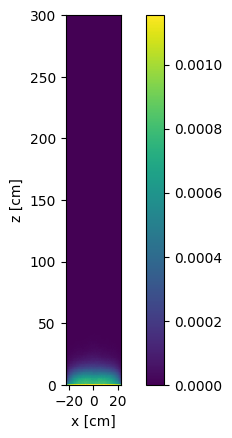

/home/agusgimenez/anaconda3/envs/openmc_develop/lib/python3.9/site-packages/openmc/tallies.py:391: RuntimeWarning: invalid value encountered in divide
  self._std_dev[nonzero] = np.sqrt((self.sum_sq[nonzero]/n -


(100, 100, 1)
[  0.45   0.45 300.  ]


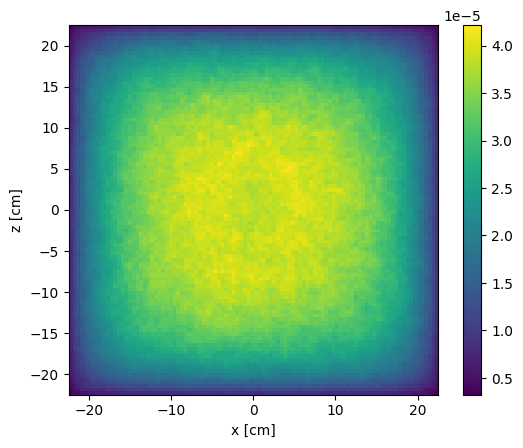

/home/agusgimenez/anaconda3/envs/openmc_develop/lib/python3.9/site-packages/openmc/tallies.py:391: RuntimeWarning: invalid value encountered in divide
  self._std_dev[nonzero] = np.sqrt((self.sum_sq[nonzero]/n -


(1, 100, 500)
[45.    0.45  0.6 ]


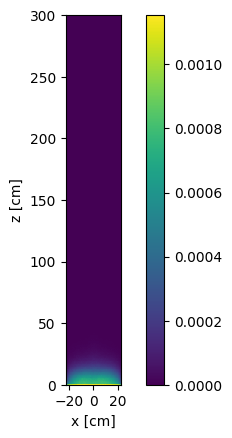

mesh 3           particle nuclide score     mean
           x    y    z                                
0          1    1    1  neutron   total  flux 6.55e-04
1          1    2    1  neutron   total  flux 7.97e-04
2          1    3    1  neutron   total  flux 8.68e-04
3          1    4    1  neutron   total  flux 9.07e-04
4          1    5    1  neutron   total  flux 9.58e-04
...      ...  ...  ...      ...     ...   ...      ...
49995      1   96  500  neutron   total  flux 0.00e+00
49996      1   97  500  neutron   total  flux 0.00e+00
49997      1   98  500  neutron   total  flux 0.00e+00
49998      1   99  500  neutron   total  flux 0.00e+00
49999      1  100  500  neutron   total  flux 0.00e+00

[50000 rows x 7 columns]

In [12]:
sp = openmc.StatePoint("statepoint.1.h5")
tally_vacio_xy  = sp.get_tally(name='vacio_xy')
tally_vacio_xz  = sp.get_tally(name='vacio_xz')
tally_vacio_yz  = sp.get_tally(name='vacio_yz')
get_df_NormVolum(tally_vacio_xz,Plot=True,ylabel='z [cm]')
get_df_NormVolum(tally_vacio_xy,Plot=True,ylabel='z [cm]')
get_df_NormVolum(tally_vacio_yz,Plot=True,ylabel='z [cm]')

In [13]:
Plano_1 = kds.surfsource.SurfaceSourceFile('surface_source.mcpl',domain={'w':[-1,1]}) 
Plano_1.save_source_file('surface_source.mcpl')
plist_1 = kds.PList("surface_source.mcpl.gz")
geometry_1 = kds.Geometry([kds.geom.Energy(),kds.geom.SurfXY(xmin=-W_total,xmax=W_total,ymin=-W_total,ymax=W_total),kds.geom.Isotrop()])
S_1 = kds.KDSource(plist_1,geometry_1)


Number of particles in file surface_source.mcpl: 13854
100% n, 0% g, 0% e-, 0% e+, 0% p, 
Saving into MCPL format
Saving into SSV format (ASCII)
Done, saved into temp.txt file
ssv_open_file: Opened file "temp.txt":
MCPL: Attempting to compress file surface_source.mcpl with gzip
MCPL: Succesfully compressed file into surface_source.mcpl.gz
Created surface_source.mcpl.gz
Done, saved into surface_source.mcpl file
Using existing file surface_source.mcpl.gz
sum_weights = 13854.0
p2 = 13854.0
N = 13854
N_eff = 13854.0


In [14]:
var_importance = [5,1,1,1,1,1]

parts,ws = S_1.plist.get(N=-1)
scaling = S_1.geom.std(parts=parts)
scaling /= var_importance

# Number of particles to use for optimization.
# A large number (1E5 or more) gives better bandwidths, but takes longer to
# compute.
N = 1E5

Using 13854 particles for fit.
Calculating bw ... 
Done
Optimal bw (silv) = [[0.04966639 3.63089799 3.56840274 0.26765373 0.26765373 0.26765373]]
Using 13854 particles for fit.
Calculating bw ... 
Using k = 10 neighbors per batch (batch_size = 10000)
Correction factor: f_k = k_float / k = 1.0
Effective total neighbors: K_eff = 13.854
batch = 1 / 1
Done
Optimal bw (knn) = [[ 0.13568357  9.91924728  9.74851657  0.73120301  0.73120301  0.73120301]
 [ 0.07088329  5.18197514  5.09278265  0.38199227  0.38199227  0.38199227]
 [ 0.06771858  4.95061625  4.86540593  0.36493752  0.36493752  0.36493752]
 ...
 [ 0.05339709  3.90363362  3.83644403  0.28775859  0.28775859  0.28775859]
 [ 0.05427266  3.96764297  3.89935164  0.29247708  0.29247708  0.29247708]
 [ 0.17279991 12.63266416 12.41522994  0.9312241   0.9312241   0.9312241 ]]
Using 10000 particles for fit.
Calculating bw ... 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   35.3s remaining:   35.3s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   55.4s remaining:   23.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.6min finished


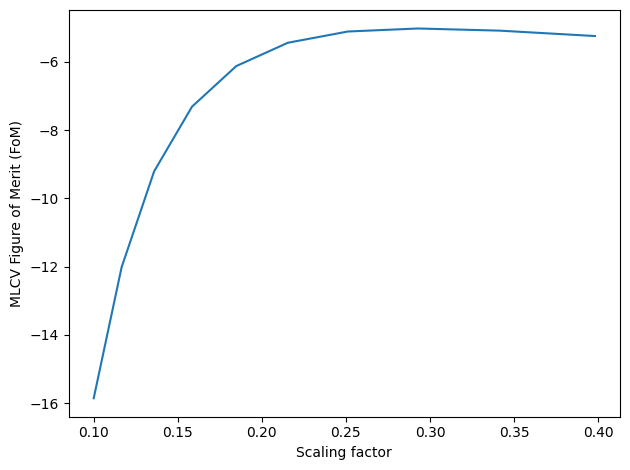

Done
Optimal bw (mlcv) = [[0.0397369  2.90499496 2.85499401 0.21414337 0.21414337 0.21414337]
 [0.0207592  1.51761633 1.49149502 0.11187196 0.11187196 0.11187196]
 [0.01983236 1.44985954 1.42490446 0.10687723 0.10687723 0.10687723]
 ...
 [0.01655225 1.21006412 1.18923642 0.08920057 0.08920057 0.08920057]
 [0.01860481 1.36011836 1.33670791 0.10026191 0.10026191 0.10026191]
 [0.01323009 0.9671956  0.95054817 0.07129738 0.07129738 0.07129738]]
Using 13854 particles for fit.


In [15]:
S_1.bw_method = "silv"
S_1.fit(N, scaling=scaling)

# Method 3: Adaptive Maximum Likelihood Cross-Validation:
# Creates a grid of adaptive bandwidths and evaluates the
# cross-validation scores on each one, which is an indicator of the
# quality of the estimation. Selects the bandwidth that optimizes
# CV score.
# kNN is used to generate the seed adaptive bandwidth.

# kNN bandwidth
S_1.bw_method = "knn"
batch_size = 10000 # Batch size for KNN search
k = 10             # Numer of neighbors per batch
S_1.fit(N, scaling=scaling, batch_size=batch_size, k=k)
bw_knn = S_1.kde.bw

# MLCV optimization of previously calculated kNN bandwidth
S_1.bw_method = "mlcv"
N_cv = int(1E4)   # Use a smaller N to reduce computation times
seed = bw_knn[:N_cv] # Use kNN BW as seed (first N elements)
grid = np.logspace(-1,-0.4,10)
S_1.fit(N_cv, scaling=scaling, seed=seed, grid=grid)
bw_cv = S_1.kde.bw

# Extend MLCV optimization to full KNN BW
bw_knn_cv = bw_knn * bw_cv[0]/bw_knn[0] # Apply MLCV factor
dim = S_1.geom.dim
bw_knn_cv *= kds.bw_silv(dim,len(bw_knn))/kds.bw_silv(dim,len(bw_cv)) # Apply Silverman factor
S_1 = kds.KDSource(plist_1, geometry_1, bw=bw_knn_cv) # Create new KDSource with full BW
S_1.fit(N=N, scaling=scaling)

In [16]:
!rm *.xml

In [17]:
xmlfile = "Source_1.xml"
S_1.save(xmlfile)


Bandwidth file: surface_source_bws
Successfully saved parameters file Source_1.xml


'Source_1.xml'

/home/agusgimenez/anaconda3/envs/openmc_develop/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=3.
  warn(msg, IDWarning)
/home/agusgimenez/anaconda3/envs/openmc_develop/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=4.
  warn(msg, IDWarning)
/home/agusgimenez/anaconda3/envs/openmc_develop/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another UniverseBase instance already exists with id=1.
  warn(msg, IDWarning)


<Axes: xlabel='x [cm]', ylabel='z [cm]'>

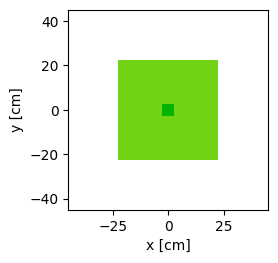

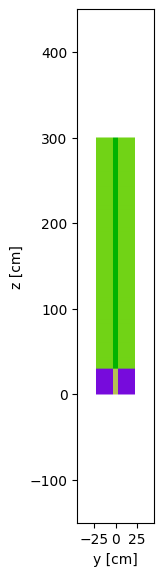

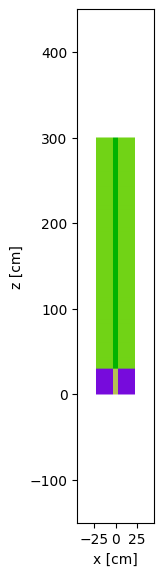

In [18]:
surf_source = openmc.ZPlane(z_Source)
surf_source.boundary_type = "transmission"


cell02_v = openmc.Cell(fill=None,cell_id=3)
cell02_v.region = +surf1_v & -surf6_v & +surf2_v & -surf5_v & +surf_source & -surf4

cell02_a = openmc.Cell(fill=mat01,cell_id=4)
cell02_a.region = +surf1_a & -surf6_a & +surf2_a & -surf5_a & +surf_source & -surf4 & ~cell01_v.region



univ02 = openmc.Universe(cells=[cell01_v,cell01_a,cell02_a,cell02_v],universe_id=1) 
univ02.plot(origin=(0.0,0.0,L/2),width=(4*W_total,4*W_total))
univ02.plot(origin=(0.0,0.0,L/2),width=(4*W_total,2*L),basis='yz')
univ02.plot(origin=(0.0,0.0,L/2),width=(4*W_total,2*L),basis='xz')




In [19]:
N = int(1E6)
param_resampled = openmc.Settings()
param_resampled.source = openmc.KernelDensitySource('Source_1.xml',resample=False)
param_resampled.run_mode = "fixed source"
param_resampled.batches = 10
param_resampled.particles = N

In [20]:
tallies_resampled = openmc.Tallies()


#FILTRO PARTICULA
Filtro_particula_neutron_resampled = openmc.ParticleFilter(['neutron'],filter_id = 0)

#GRILLA

mesh_vacio_xy_resampled = openmc.RegularMesh.from_domain(domain=univ02,dimension=(100,100,1),mesh_id=1)
mesh_vacio_xy_resampled.lower_left = [-W_total, -W_total, z_Source]
mesh_vacio_xy_resampled.upper_rigth = [W_total, W_total, L]

mesh_vacio_xz_resampled = openmc.RegularMesh.from_domain(domain=univ02,dimension=(100,1,500),mesh_id=2)
mesh_vacio_xz_resampled.lower_left = [-W_total, -W_total, z_Source]
mesh_vacio_xz_resampled.upper_rigth = [W_total, W_total, L]

mesh_vacio_yz_resampled = openmc.RegularMesh.from_domain(domain=univ02,dimension=(1,100,500),mesh_id=3)
mesh_vacio_yz_resampled.lower_left = [-W_total, -W_total, z_Source]
mesh_vacio_yz_resampled.upper_rigth = [W_total, W_total, L]

#FILTRO ESPACIAL

filt_vacio_xy_resampled = openmc.filter.MeshFilter(mesh_vacio_xy_resampled,filter_id=1)
filt_vacio_xz_resampled = openmc.filter.MeshFilter(mesh_vacio_xz_resampled,filter_id=2)
filt_vacio_yz_resampled = openmc.filter.MeshFilter(mesh_vacio_yz_resampled,filter_id=3)


#Tallys

dist_vacio_xy_resampled = openmc.Tally(name='vacio_xy' , tally_id=1)
dist_vacio_xy_resampled.scores = ["flux"]
dist_vacio_xy_resampled.filters = [filt_vacio_xy_resampled, Filtro_particula_neutron_resampled]
tallies_resampled.append(dist_vacio_xy_resampled)

dist_vacio_xz_resampled = openmc.Tally(name='vacio_xz' , tally_id=2)
dist_vacio_xz_resampled.scores = ["flux"]
dist_vacio_xz_resampled.filters = [filt_vacio_xz_resampled, Filtro_particula_neutron_resampled]
tallies_resampled.append(dist_vacio_xz_resampled)

dist_vacio_yz_resampled = openmc.Tally(name='vacio_yz' , tally_id=3)
dist_vacio_yz_resampled.scores = ["flux"]
dist_vacio_yz_resampled.filters = [filt_vacio_yz_resampled, Filtro_particula_neutron_resampled]
tallies_resampled.append(dist_vacio_yz_resampled)

/home/agusgimenez/anaconda3/envs/openmc_develop/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=0.
  warn(msg, IDWarning)
/home/agusgimenez/anaconda3/envs/openmc_develop/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another MeshBase instance already exists with id=1.
  warn(msg, IDWarning)
/home/agusgimenez/anaconda3/envs/openmc_develop/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another MeshBase instance already exists with id=2.
  warn(msg, IDWarning)
/home/agusgimenez/anaconda3/envs/openmc_develop/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another MeshBase instance already exists with id=3.
  warn(msg, IDWarning)
/home/agusgimenez/anaconda3/envs/openmc_develop/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=1.
  warn(msg, IDWarning)
/home/agusgimenez/anaconda3/envs/openmc_develop/lib/python3.9/site-packages/openmc/mixin.py:70

In [21]:
geom = openmc.Geometry(univ02)
geom.export_to_xml()
mats = openmc.Materials(univ02.get_all_materials().values())
mats.cross_sections = openmc_data
mats.export_to_xml()


param_resampled.export_to_xml()

tallies_resampled.export_to_xml()

In [22]:
!rm statepoint.*.h5
!rm summary.h5
openmc.run(threads=1)

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

KeyboardInterrupt: 

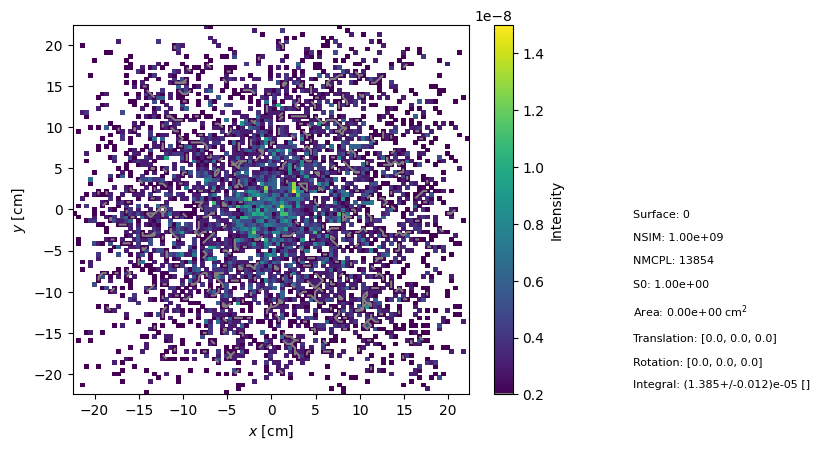

In [ ]:
Plano_1.plot_distribution(vars=['x','y'],bins=[100,100], scales=['linear','linear'], norm_vars=[], info=True, zscale='linear')

In [ ]:
Plano_1.get_pandas_dataframe()

,id,type,E,x,y,z,u,v,w,t,...,pz,userflags,R,theta,mu,psi,phi,ln(E0/E),log(t),lambda
0,0,2112.0,1.540350e+00,-0.843907,1.641265,30.0,-0.111670,-0.033332,0.993186,0.000017,...,0.0,0.0,1.845516,2.045724,0.993186,0.116804,-2.851522,2.563722,-4.766254,0.000230
1,1,2112.0,5.129719e-08,-6.340143,-18.008518,30.0,0.071237,0.148647,0.986321,0.135998,...,0.0,0.0,19.091992,-1.909308,0.986321,0.165591,1.123896,19.781362,-0.866469,1.262819
2,2,2112.0,3.735357e-08,-6.467502,-18.021423,30.0,-0.742267,-0.308750,-0.594737,0.136814,...,0.0,0.0,19.146809,-1.915359,-0.594737,2.207735,-2.747407,20.098570,-0.863870,1.479864
3,3,2112.0,6.344312e-08,-7.329080,-17.854048,30.0,-0.899286,0.428650,0.086854,0.142175,...,0.0,0.0,19.299804,-1.960321,0.086854,1.483833,2.696795,19.568854,-0.847176,1.135522
4,4,2112.0,4.434614e-08,-7.457963,-17.798727,30.0,0.793410,-0.506381,-0.337756,0.142871,...,0.0,0.0,19.298080,-1.967588,-0.337756,1.915328,-0.568059,19.926972,-0.845056,1.358188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13849,13849,2112.0,3.174085e-08,1.060320,5.337242,30.0,0.402531,0.371713,0.836539,0.484834,...,0.0,0.0,5.441546,1.374685,0.836539,0.579860,0.745614,20.261394,-0.314407,1.605383
13850,13850,2112.0,7.100484e-08,-0.995125,5.294375,30.0,-0.886809,-0.287219,-0.362043,0.493338,...,0.0,0.0,5.387084,1.756588,-0.362043,1.941255,-2.828375,19.456250,-0.306855,1.073356
13851,13851,2112.0,7.944302e-08,0.893657,7.883329,30.0,0.339029,0.692766,0.636503,0.534048,...,0.0,0.0,7.933820,1.457918,0.636503,0.880841,1.115677,19.343958,-0.272420,1.014752
13852,13852,2112.0,9.251034e-08,0.975312,9.179729,30.0,-0.472542,-0.130679,-0.871566,0.542011,...,0.0,0.0,9.231395,1.464947,-0.871566,2.629183,-2.871790,19.191678,-0.265992,0.940357
